# Модель предсказания срывов поставок на основе LightGBM

## Библиотеки и модули

Загрузка библиотек и модулей, используемых при решении. 
- Модель: **LGBMClassifier** из библиотеки **LightGBM**
- Предобработчик данных для модели: **DataPreprocessor** (из модуля **helper.data**)
- Борьба с дисбалансом классов: **RandomOverSampler** (библиотека **imbalanced-learn**)
- Разделение на тренировочную и тестовую выборки, кросс-валидация, оценка решения: 
    - библиотека **scikit-learn**
    - **valid_predictions** (из модуля **helpers.validation**)
- Работа с датасетом: библиотека **pandas** 
- Работа с файловой системой: модуль **os**

In [1]:
# Модель
import lightgbm 
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Пайплайн
from sklearn.pipeline import Pipeline
from helpers.data import DataPreprocessor
from helpers.validation import valid_predictions

# Данные
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import shap

# Настройки вывода
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Загрузка датасетов

In [2]:
# Пути
ROOT = os.getcwd()
TRAIN_DATASET = os.path.join(ROOT, '../data/train_AIC.csv')
BALANCED_DATASET = os.path.join(ROOT, '../data/balanced_train.csv')
TEST_DATASET = os.path.join(ROOT, '../data/test_AIC.csv')
SUBMISSION_PATH = os.path.join(ROOT, '../submissions/')
MODEL_SAVE_PATH = os.path.join(ROOT, '../output/lgbm_model.dat')

# Функции
def make_predictions(model: object | Pipeline, X_test: pd.DataFrame) -> None:
    """ Функция создания предсказаний для тестовой выборки.
    
    Обучает переданную модель на сбалансированном датасете, учитывая выбросы.
    Предсказания сохраняются с помощью функции save_submission.
    
    Параметры:
        model: Модель или пайплайн, используемый для обучения и предсказания меток
            тестовой выборки.
        X_test: Тестовая выборка, для которой будут сделаны предсказания.
            Экземпляр pandas.DataFrame."""
    
    # Загрузка сбалансированного датасета
    balanced_df = pd.read_csv(BALANCED_DATASET, index_col=0)
    
    # Обрезка негативных записей до числа позитивных
    first_negatives = balanced_df[balanced_df['y'] == 0][:balanced_df[balanced_df['y'] == 1]['y'].count()]
    balanced_df = pd.concat([balanced_df[balanced_df['y'] == 1], first_negatives])

    # Удаление выбросов
    balanced_df = balanced_df[balanced_df['Длительность'] < 400]
    balanced_df = balanced_df[(balanced_df['Сумма'] > 2) & (balanced_df['Сумма'] < 10)]
    balanced_df = balanced_df[balanced_df['До поставки'] < 300]
    balanced_df = balanced_df[balanced_df['Дней между 0_1'] < 400]
    balanced_df = balanced_df[balanced_df['Количество изменений после согласований'] < 2000]
    balanced_df = balanced_df[balanced_df['Количество'] < 300000]
    
    # Разделение независимых и независимых переменных
    X, y = balanced_df.iloc[:, :-1], balanced_df.iloc[:, -1]   

    # Обучение модели и создание предсказаний для тестовой выборки
    model.fit(X, y)
    preds = model.predict(X_test)

    # Сохранение предсказаний
    save_submission(preds, 'submission')
    
def save_submission(preds: list | pd.DataFrame | pd.arrays.PandasArray, subname: str) -> None:
    subname = os.path.join(SUBMISSION_PATH, f'{subname}.csv')
    submit_df = pd.DataFrame({'id': test_df.index, 'value': preds})
    submit_df.to_csv(subname, index=False)


# Загрузка датасетов
train_df = pd.read_csv(TRAIN_DATASET)
test_df = pd.read_csv(TEST_DATASET)

# Удаление дубликатов из тренировочной выборки
train_df = train_df.drop_duplicates()

# Разделение выборки на тренировочную и тестовую
X, y = train_df.iloc[:, :-1], train_df.iloc[:, -1]   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Удаление выбросов из тренировочной выборки
X_train = pd.concat([X_train, y_train], axis=1) # Объединяем X_train и y_train
X_train = X_train[X_train['Длительность'] < 400]
X_train = X_train[(X_train['Сумма'] > 2) & (X_train['Сумма'] < 10)]
X_train = X_train[X_train['До поставки'] < 300]
X_train = X_train[X_train['Дней между 0_1'] < 400]
X_train = X_train[X_train['Количество изменений после согласований'] < 2000]
X_train = X_train[X_train['Количество'] < 300000]

# Отделяем метки классов от признаков
y_train = X_train['y']
X_train = X_train.drop('y', axis=1)

# Общий датасет для большего числа записей, используемых на кросс-валидации
X_general, y_general = train_df.iloc[:, :-1], train_df.iloc[:, -1]

## Тестирование модели

### Создание пайплайна

- Кросс-валидация: используется X_general и y_general, не содержащие дубликатов.
- Валидация на тестовой выборке (X_test, y_test): используется X_res и y_res, полученные с помощью рандомного оверсемплирования X_train и y_train.
- Модель: LGBMClassifier из библиотеки LightGBM
- Параметры модели: подобраны с учётом результатов подбора гиперпараметров, а также ручных корректировок для повышения обобщающей способности.
- Пайплайн:
    - Предобработчик: кастомный предобработчик DataPreproccessor из модуля helper.data, совмещающий BinaryEncoder, RobustScaler, экстракцию признаков.
    - Модель: LGBMClassifier

In [3]:
# Создание оверсемпл-датасета (отбор рандомных записей)
oversampler = RandomOverSampler(random_state=42)
X_res, y_res = oversampler.fit_resample(X_train, y_train)

# Параметры модели
parameters = {
    'objective': 'binary',
    'force_col_wise': True,
    'learning_rate': 0.25595401399911066, 
    'n_estimators': 2122, 
    'max_depth': 14, 
    'max_bin': 163, 
    'num_leaves': 176, 
    'reg_lambda': 0.15394653650963538, 
    }

# Предобработчик и модель
data_preprocessor = DataPreprocessor()
model = LGBMClassifier(**parameters, n_jobs=-1)

# Пайплайн
pipeline = Pipeline([
    ('data_preproc', data_preprocessor),
    ('model', model)
])

### Кросс-валидация
- Для кроссвалидации используется алгоритм Stratified K-Fold, учитывающий распределение классов. 
- Число используемых фолдов: 5.
- Метрика: F1-macro

In [ ]:
# Запуск кросс-валидации
cv_scores = cross_val_score(pipeline, X_general, y_general, cv=StratifiedKFold(n_splits=5), scoring='f1_macro', n_jobs=-1)
print(f'Mean F1-macro: {cv_scores.mean()}')

### Валидация на тестовой выборке

In [4]:
# Обучение модели и получение предсказаний для тестовой выборки
pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)

[LightGBM] [Info] Number of positive: 28431, number of negative: 169286
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 197717, number of used features: 103
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143796 -> initscore=-1.784109
[LightGBM] [Info] Start training from score -1.784109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


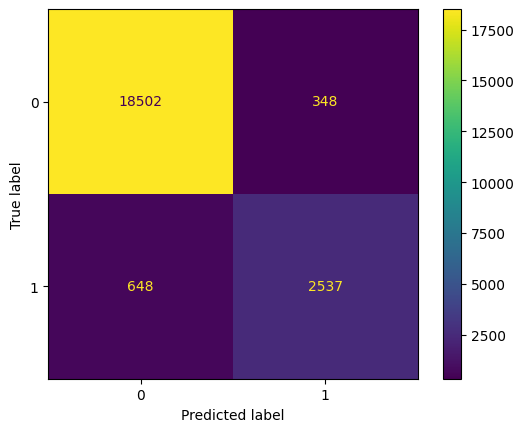

              precision    recall  f1-score   support

           0    0.96616   0.98154   0.97379     18850
           1    0.87938   0.79655   0.83591      3185

    accuracy                        0.95480     22035
   macro avg    0.92277   0.88904   0.90485     22035
weighted avg    0.95362   0.95480   0.95386     22035

F1-macro: 0.9048519032341975
ROC-AUC score: 0.8890423861852434
Accuracy: 0.9547991831177672


In [5]:
# Вывод результатов валидации
valid_predictions(y_test, preds, pipeline.classes_)

### Интерпретация модели

Для интерпретации модели можно: 
- Построить график важности признаков.
- Построить график SHAP

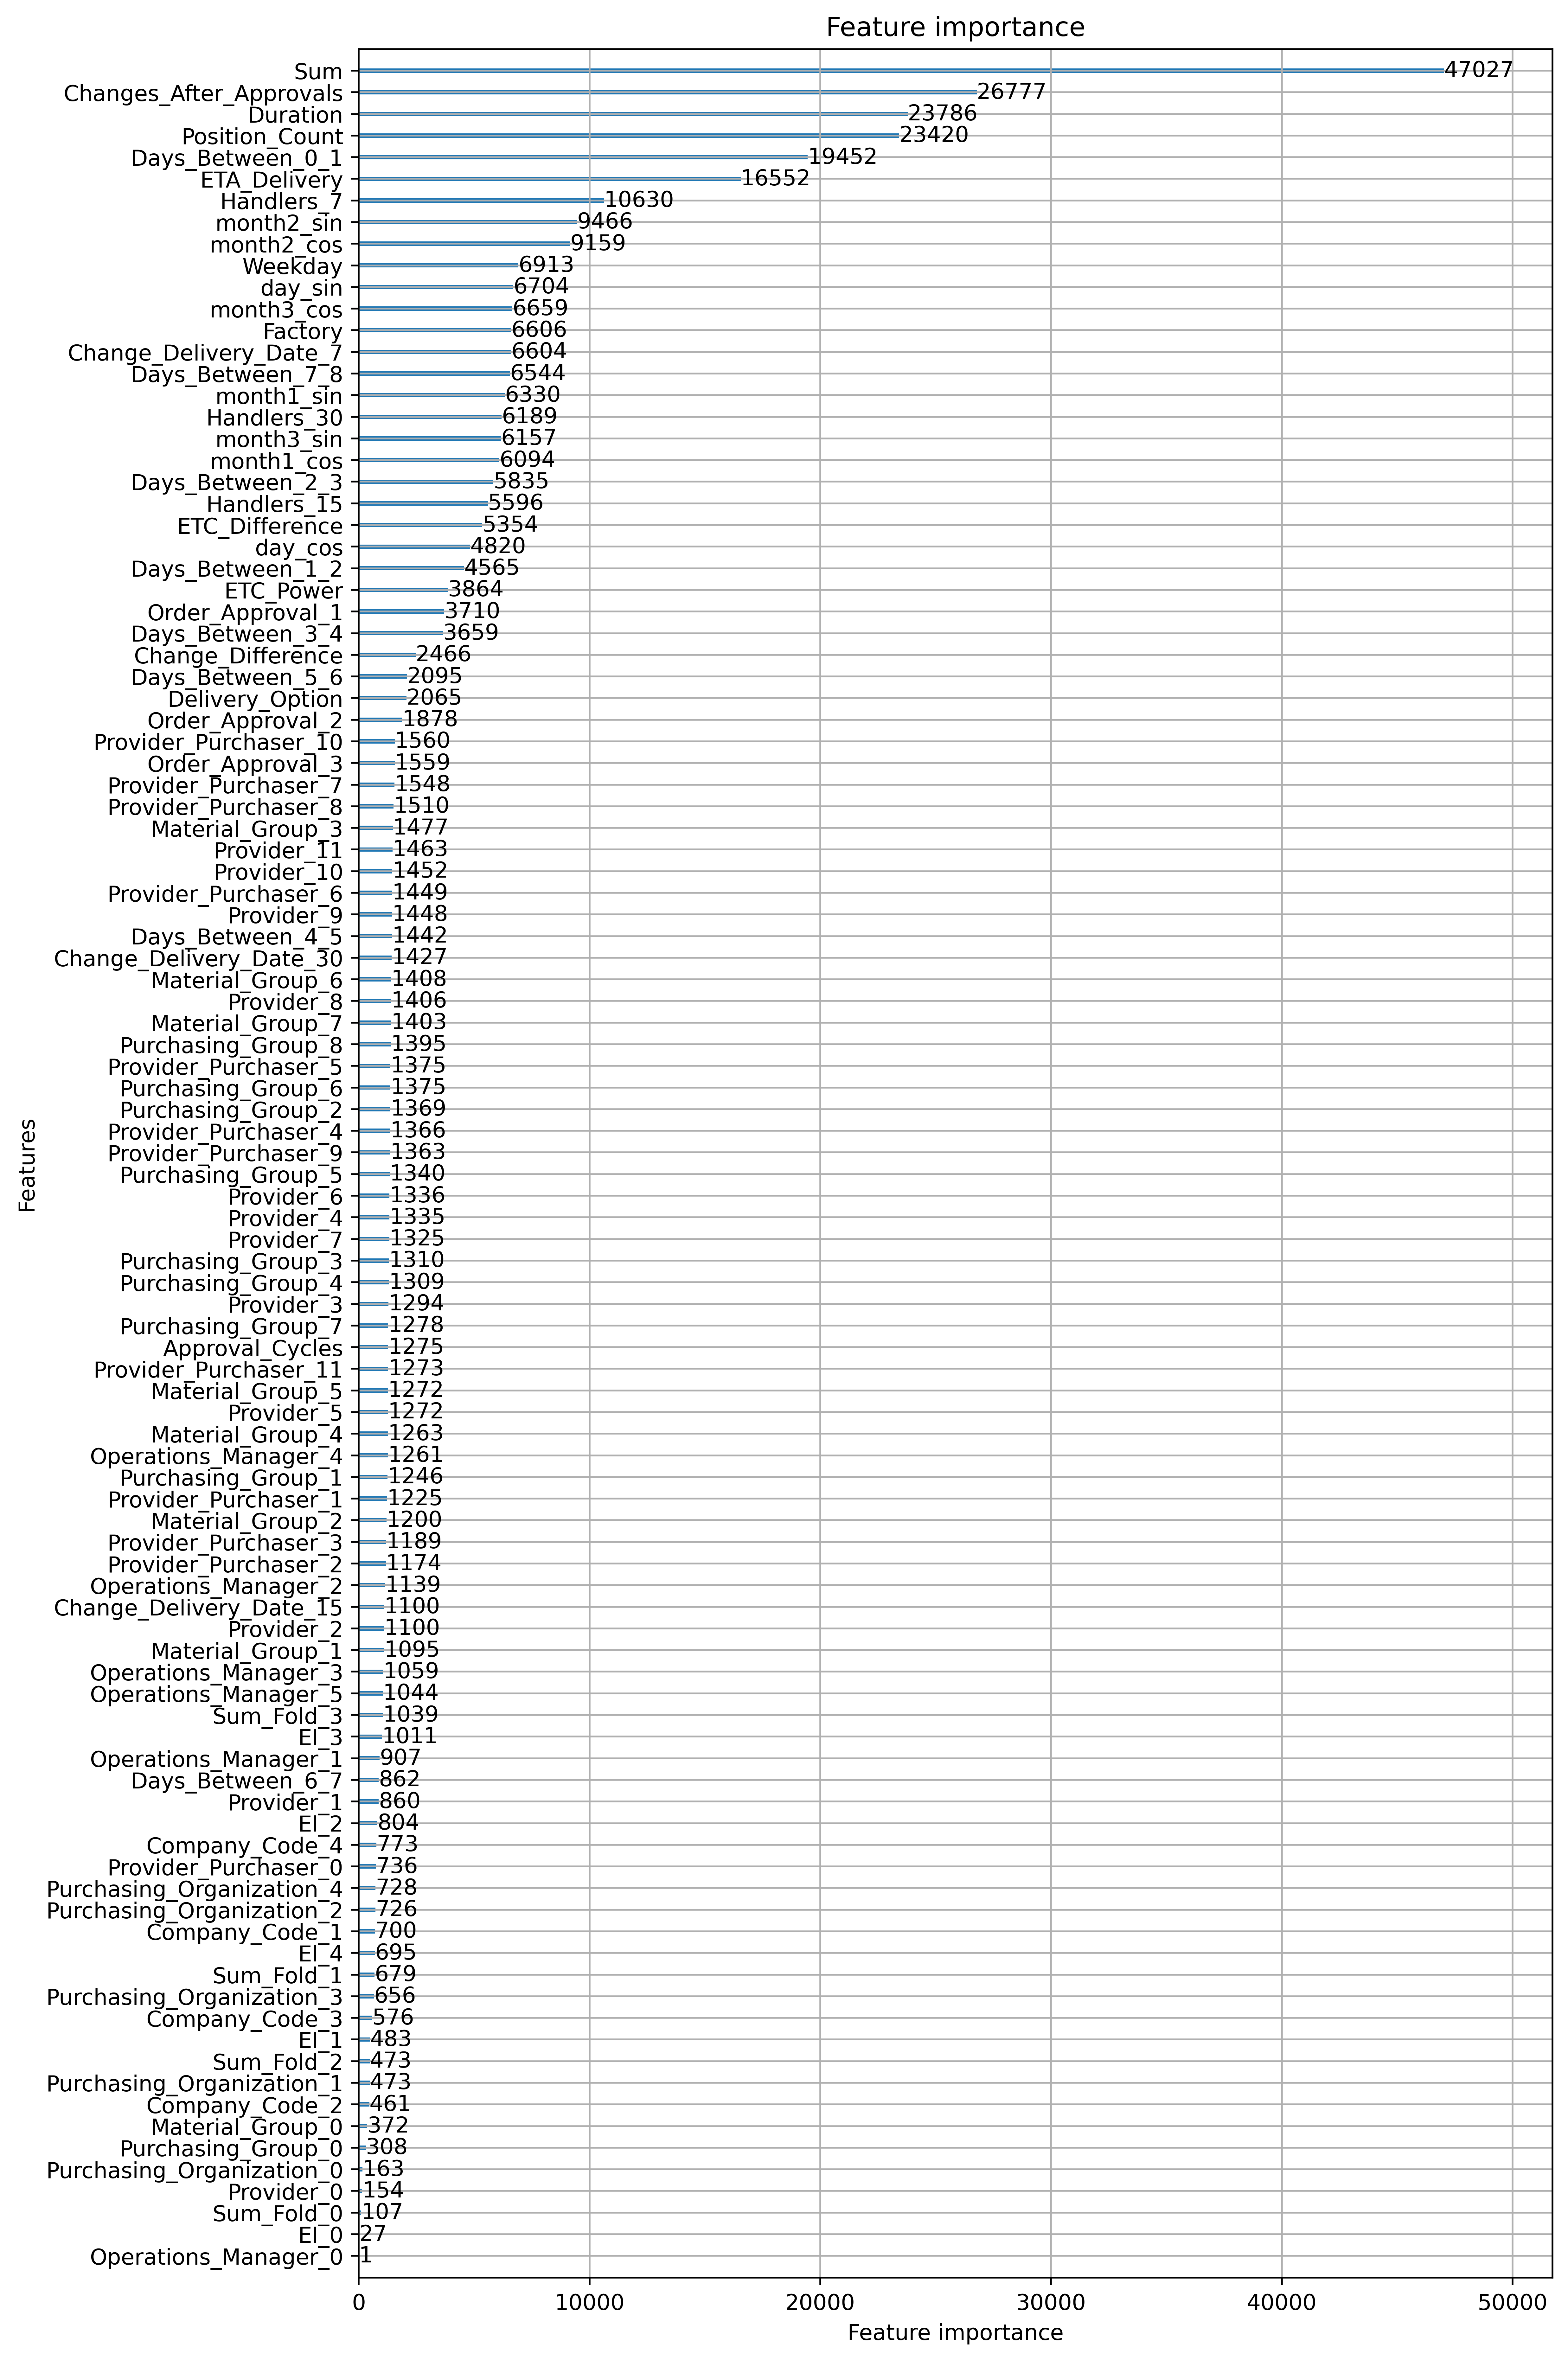

In [6]:
# Построение 
lightgbm.plot_importance(pipeline['model'], figsize=(10, 15), dpi=500)
plt.tight_layout()
plt.show()

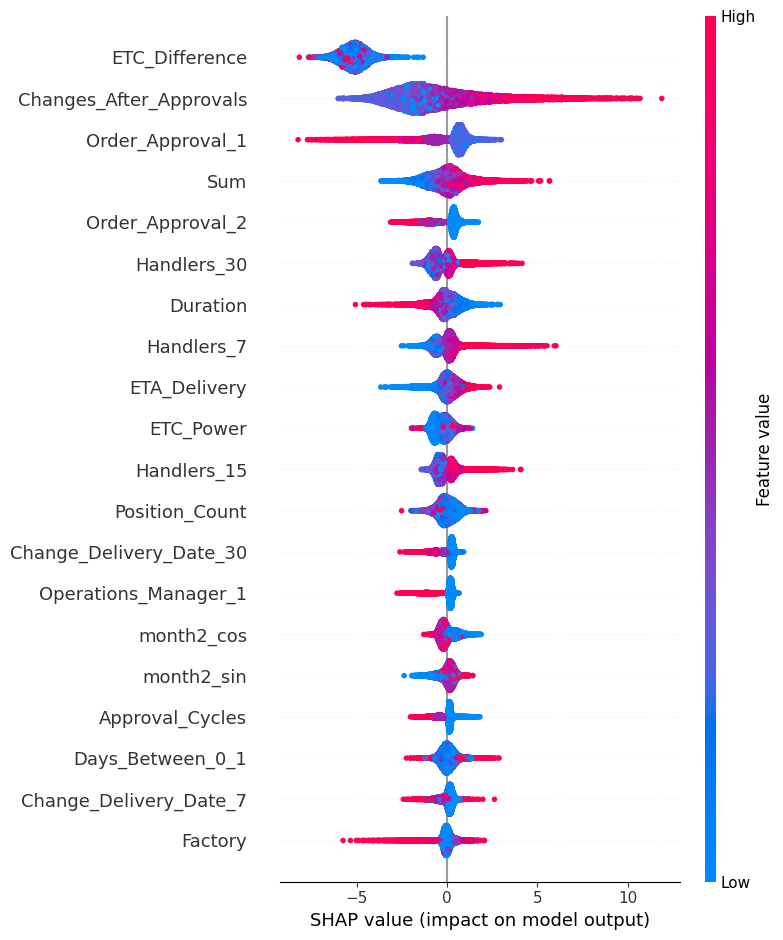

In [9]:
data_preprocessor_shap = DataPreprocessor()
data_preprocessor_shap.fit(X_res, y_res)
X_test_shap = data_preprocessor_shap.transform(X_test)
shap_values = shap.TreeExplainer(pipeline['model']).shap_values(X_test_shap)
shap.summary_plot(shap_values[1], X_test_shap)

## Получение предсказаний для AI Challenge

In [10]:
# Предсказание для тестовой выборки AI Challenge
make_predictions(pipeline, test_df)

[LightGBM] [Info] Number of positive: 189642, number of negative: 188073
[LightGBM] [Info] Total Bins 2613
[LightGBM] [Info] Number of data points in the train set: 377715, number of used features: 103
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502077 -> initscore=0.008308
[LightGBM] [Info] Start training from score 0.008308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
